# Phase features


## Most Relevant Phase Features

### I/Q Imbalance:
- Relevance: This feature directly affects the position of the constellation points and is highly sensitive to the specific analog hardware (e.g., mixers, amplifiers) used in a transmitter.
- Why: Because even slight mismatches in gain and phase between the I and Q channels can be consistently measured and are very hard to replicate exactly across different devices, making them an excellent basis for fingerprinting.
- Model: The ideal baseband signal is represented as:

$$
s(t) = I(t)·cos(ω₍c₎t) – Q(t)·sin(ω₍c₎t).
$$

With I/Q imbalance, the I and Q channels are affected by gain and phase errors. One common model is:

$$
r(t) = I(t) + j·e^(jφ)·(1+ε)·Q(t)
$$

where ε represents the relative gain error and φ the phase error. Alternatively, one may express it as a rotation:

$$
[ I₍r₎ Q₍r₎ ]ᵀ = [ cosθ –sinθ; sinθ cosθ ] · [ I(t); Q(t) ] 
$$

with θ capturing the imbalance angle.
- Explanation: These mismatches shift the constellation points away from their ideal locations. They are inherent to the hardware’s analog front-end and serve as a robust signature for a specific transmitter.




# Libraries

In [2]:
import numpy as np
from analysis_functions import *


2025-04-04 10:12:57.020573: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 10:12:57.227110: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 10:12:57.403520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 10:12:57.600994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 10:12:57.651746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 10:13:00.071514: W tensorflow/compiler/tf2tensorrt/utils/p

# Load Signal

In [3]:

data_dir = "../../data/"

sufix = 10
sample = 5  #0 - 9999
fs = 25e6  #sample_frequency
dt = 1/25e6 #period

samples = load_samples(data_dir,f"{sufix:03d}")

# Obtain I[0] and Q[1] signals
iq_signal = samples[sample,:,]
i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]


print('Done')

Done


In [4]:
iq_signal = samples[sample,:,]
print(iq_signal[:,].shape)
print(i_signal.shape)

(11000, 2)
(11000,)


# I/Q Imbalance (Gain & Phase Mismatch)

In [5]:
def estimate_iq_imbalance(iq_signal):
    """
    Estimate the gain error (ε) and phase error (φ) from an IQ signal.

    Parameters:
        iq_signal (np.ndarray): A two-dimensional array of shape (N, 2) where:
                                - Column 0 contains the I samples.
                                - Column 1 contains the Q samples.
                                For example, your data may have shape (11000, 2).

    Returns:
        epsilon_est (float): Estimated relative gain error.
        phi_est (float): Estimated phase error in radians.
    """
    # Check that the input has the expected shape.
    if iq_signal.ndim != 2 or iq_signal.shape[1] != 2:
        raise ValueError("IQ signal must be a 2D array with shape (N, 2)")
    
    # Remove any DC offset (demean the signals)
    I = iq_signal[:, 0] - np.mean(iq_signal[:, 0])
    Q = iq_signal[:, 1] - np.mean(iq_signal[:, 1])
    
    # Compute the variances and covariance of the de-meaned signals
    var_I = np.var(I)
    var_Q = np.var(Q)
    cov_IQ = np.mean(I * Q)
    
    # Estimate the phase error using the relation:
    #   cov(I, Q) / var(Q) = -tan(φ)
    phi_est = -np.arctan(cov_IQ / var_Q)
    
    # Compute the denominator for the gain estimation:
    #   (1+ε)^2 = var(Q) / (var(I)*cos²(φ) - var(Q)*sin²(φ))
    denom = var_I * (np.cos(phi_est)**2) - var_Q * (np.sin(phi_est)**2)
    if denom <= 0:
        raise ValueError("Invalid covariance values: denominator is non-positive.")
    
    gain_factor_squared = var_Q / denom
    epsilon_est = np.sqrt(gain_factor_squared) - 1  # Gain mismatch estimate

    return epsilon_est, phi_est

epsilon_est, phi_est = estimate_iq_imbalance(iq_signal)
print("Estimated Gain Error (ε):", epsilon_est)
print("Estimated Phase Error (φ in radians):", phi_est)

Estimated Gain Error (ε): 4.260724315990881
Estimated Phase Error (φ in radians): -0.7793631


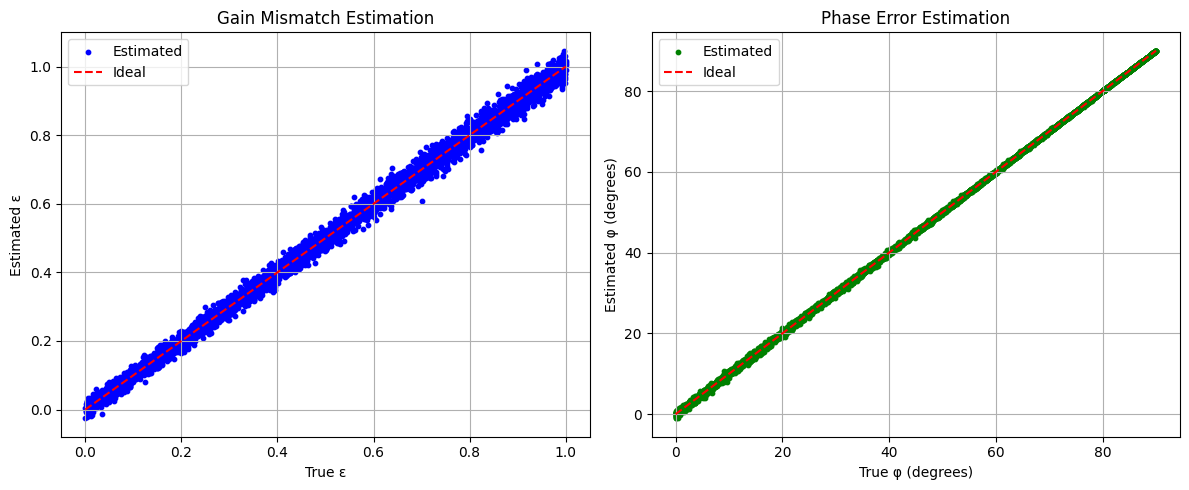

Average absolute error in ε estimation: 0.013174106989647232
Average absolute error in φ estimation (degrees): 0.20055142142784552


In [7]:
def simulate_iq_signal(num_samples, epsilon_true, phi_true, seed=None):
    """
    Simulate an IQ signal with a specified gain and phase imbalance.
    
    Parameters:
        num_samples (int): Number of samples to simulate.
        epsilon_true (float): True gain mismatch (relative gain error).
        phi_true (float): True phase error in radians.
        seed (int, optional): Random seed for reproducibility.
    
    Returns:
        iq_signal (np.ndarray): Simulated IQ signal with shape (num_samples, 2).
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate ideal (balanced) I and Q signals.
    I_ideal = np.random.randn(num_samples)
    Q_ideal = np.random.randn(num_samples)
    
    # Introduce imbalance according to the model:
    # I_obs = I_ideal - sin(phi_true) * (1+epsilon_true) * Q_ideal
    # Q_obs = cos(phi_true) * (1+epsilon_true) * Q_ideal
    I_obs = I_ideal - np.sin(phi_true) * (1 + epsilon_true) * Q_ideal
    Q_obs = np.cos(phi_true) * (1 + epsilon_true) * Q_ideal
    
    # Combine I and Q into a two-column array.
    iq_signal = np.column_stack((I_obs, Q_obs))
    return iq_signal

def robust_test():
    """
    Run a robust test by simulating multiple IQ signals with known imbalances,
    estimating the imbalance parameters, and plotting the comparison.
    """
    fs = 25e6            # Sampling frequency (25 MHz); not directly used here.
    num_samples = 10000  # Number of samples per test signal.
    num_tests = 5000     # Total number of test cases.
    
    # Define ranges for the true imbalance parameters.
    # Here, epsilon (gain error) is chosen between 0.0 and 1.0 (relative gain error),
    # and phi (phase error) is chosen between 0 and 90° (in radians).
    epsilon_range = (0.0, 1.0)
    phi_range = (0, np.deg2rad(90))
    
    # Lists to hold true and estimated parameters.
    true_epsilons, est_epsilons = [], []
    true_phis, est_phis = [], []
    
    # Set a seed for reproducibility across tests.
    np.random.seed(42)
    
    for _ in range(num_tests):
        # Randomly select true imbalance parameters within the specified ranges.
        epsilon_true = np.random.uniform(*epsilon_range)
        phi_true = np.random.uniform(*phi_range)
        
        # Simulate the IQ signal with the specified imbalance.
        iq_signal = simulate_iq_signal(num_samples, epsilon_true, phi_true)
        
        # Estimate the imbalance parameters from the simulated IQ signal.
        try:
            epsilon_est, phi_est = estimate_iq_imbalance(iq_signal)
        except ValueError as e:
            print("Estimation error:", e)
            continue
        
        true_epsilons.append(epsilon_true)
        est_epsilons.append(epsilon_est)
        true_phis.append(phi_true)
        est_phis.append(phi_est)
    
    # Convert lists to arrays for easier manipulation.
    true_epsilons = np.array(true_epsilons)
    est_epsilons = np.array(est_epsilons)
    true_phis = np.array(true_phis)
    est_phis = np.array(est_phis)
    
    # ----------------------
    # Plot Gain Error (ε)
    # ----------------------
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(true_epsilons, est_epsilons, c='blue', s=10, label="Estimated")
    # Ideal reference line: y = x.
    plt.plot([true_epsilons.min(), true_epsilons.max()],
             [true_epsilons.min(), true_epsilons.max()], 'r--', label="Ideal")
    plt.xlabel("True ε")
    plt.ylabel("Estimated ε")
    plt.title("Gain Mismatch Estimation")
    plt.legend()
    plt.grid(True)
    
    # ----------------------
    # Plot Phase Error (φ)
    # ----------------------
    plt.subplot(1, 2, 2)
    true_phis_deg = np.rad2deg(true_phis)
    est_phis_deg = np.rad2deg(est_phis)
    plt.scatter(true_phis_deg, est_phis_deg, c='green', s=10, label="Estimated")
    plt.plot([true_phis_deg.min(), true_phis_deg.max()],
             [true_phis_deg.min(), true_phis_deg.max()], 'r--', label="Ideal")
    plt.xlabel("True φ (degrees)")
    plt.ylabel("Estimated φ (degrees)")
    plt.title("Phase Error Estimation")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # ----------------------
    # Print Summary Metrics
    # ----------------------
    epsilon_error = np.mean(np.abs(true_epsilons - est_epsilons))
    phi_error = np.mean(np.abs(np.rad2deg(true_phis - est_phis)))
    print("Average absolute error in ε estimation:", epsilon_error)
    print("Average absolute error in φ estimation (degrees):", phi_error)

if __name__ == '__main__':
    robust_test()


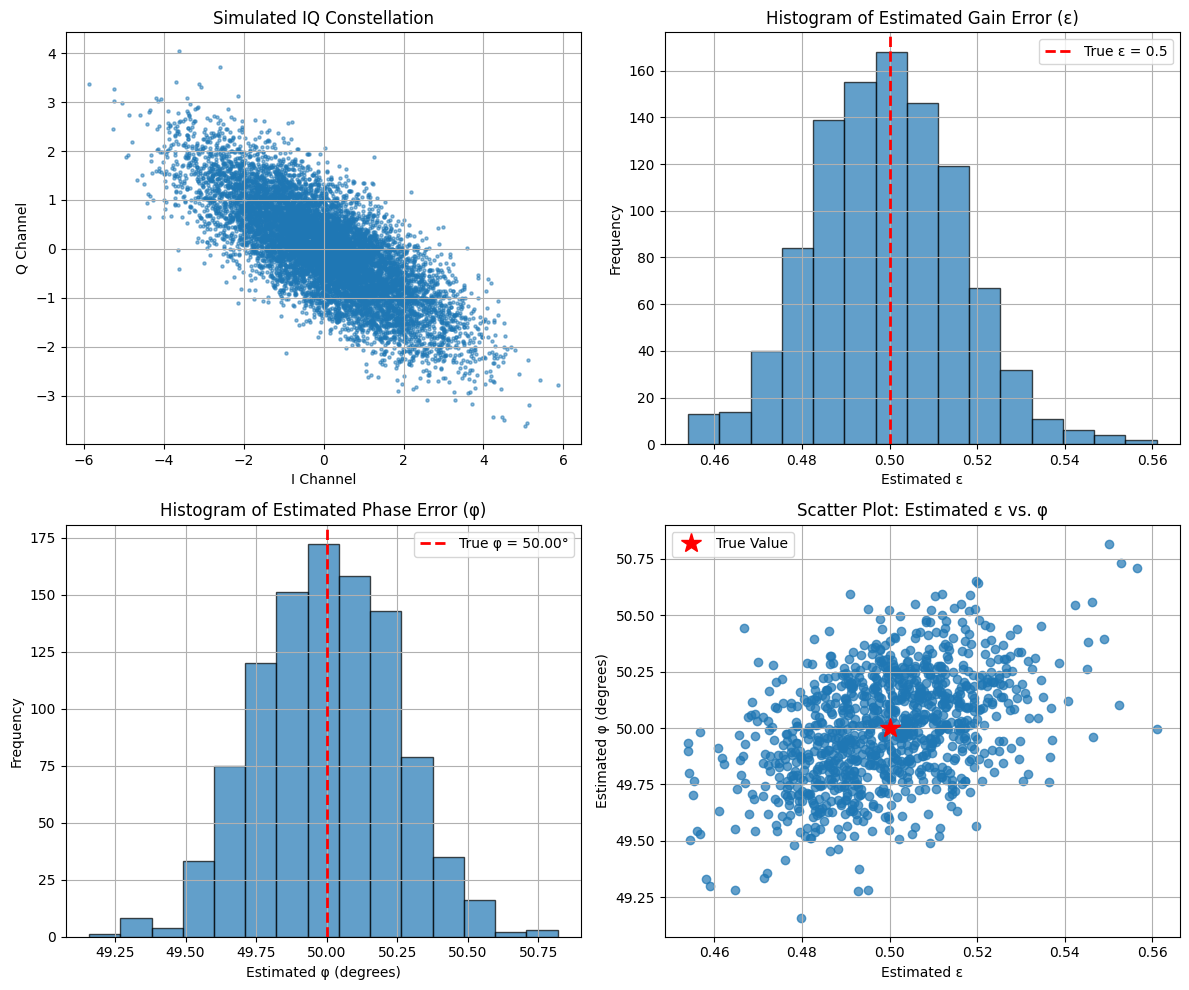

Simulation Results:
True Gain Error (ε): 0.5
Mean Estimated Gain Error (ε): 0.4992369327879852
Std Dev of Estimated Gain Error (ε): 0.0166888133096291

True Phase Error (φ in degrees): 50.0
Mean Estimated Phase Error (φ in degrees): 50.00082395208482
Std Dev of Estimated Phase Error (φ in degrees): 0.244363360750679


Real IQ signal data found. Processing real data...
Estimated Gain Error (ε) from real data: 4.260724315990881
Estimated Phase Error (φ in degrees) from real data: -44.654213


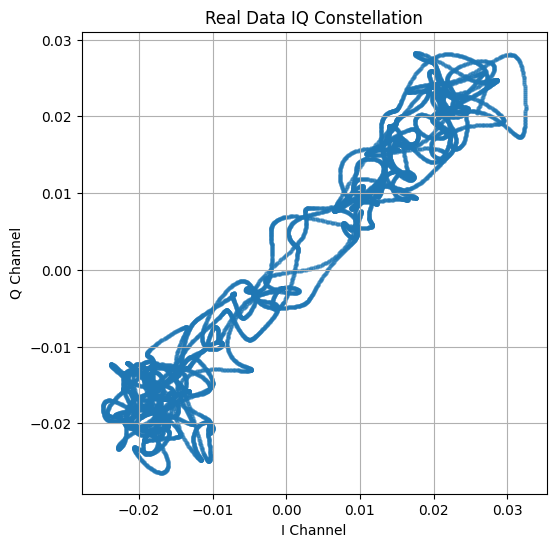

In [8]:
def simulate_iq_signal(num_samples, epsilon, phi, seed=None):
    """
    Generate a simulated IQ signal with a known imbalance.
    
    Parameters:
        num_samples (int): Number of samples to simulate.
        epsilon (float): Relative gain error (e.g., 0.1 for 10% gain error).
        phi (float): Phase error in radians (e.g., np.deg2rad(5) for 5° phase error).
        seed (int, optional): Random seed for reproducibility.
    
    Returns:
        iq_signal (np.ndarray): Simulated IQ signal with shape (num_samples, 2).
                                The first column contains the I samples,
                                and the second column contains the Q samples.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate ideal (balanced) I and Q channels as independent Gaussian samples.
    I_ideal = np.random.randn(num_samples)
    Q_ideal = np.random.randn(num_samples)
    
    # Introduce imbalance using the model:
    # I_obs = I_ideal - sin(phi) * (1 + epsilon) * Q_ideal
    # Q_obs = cos(phi) * (1 + epsilon) * Q_ideal
    I_obs = I_ideal - np.sin(phi) * (1 + epsilon) * Q_ideal
    Q_obs = np.cos(phi) * (1 + epsilon) * Q_ideal
    
    # Combine into a two-dimensional array with shape (num_samples, 2)
    iq_signal = np.column_stack((I_obs, Q_obs))
    return iq_signal

def estimate_iq_imbalance(iq_signal):
    """
    Estimate the gain error (ε) and phase error (φ) from an IQ signal.
    
    Parameters:
        iq_signal (np.ndarray): A two-dimensional array with shape (N, 2)
                                where column 0 contains I samples and
                                column 1 contains Q samples.
    
    Returns:
        epsilon_est (float): Estimated relative gain error.
        phi_est (float): Estimated phase error in radians.
    """
    # Verify that the input has the correct shape.
    if iq_signal.ndim != 2 or iq_signal.shape[1] != 2:
        raise ValueError("IQ signal must be a 2D array with shape (N, 2)")
    
    # Remove any DC offset by demeaning the I and Q channels.
    I = iq_signal[:, 0] - np.mean(iq_signal[:, 0])
    Q = iq_signal[:, 1] - np.mean(iq_signal[:, 1])
    
    # Compute variances and covariance of the de-meaned signals.
    var_I = np.var(I)
    var_Q = np.var(Q)
    cov_IQ = np.mean(I * Q)
    
    # Estimate phase error using: cov(I, Q) / var(Q) = -tan(φ)
    phi_est = -np.arctan(cov_IQ / var_Q)
    
    # Compute (1+ε)² using the relation:
    # (1+ε)² = var(Q) / (var(I)*cos²(φ) - var(Q)*sin²(φ))
    denom = var_I * (np.cos(phi_est)**2) - var_Q * (np.sin(phi_est)**2)
    if denom <= 0:
        raise ValueError("Invalid covariance values: denominator is non-positive.")
    
    gain_factor_squared = var_Q / denom
    epsilon_est = np.sqrt(gain_factor_squared) - 1  # Estimated gain error
    
    return epsilon_est, phi_est

def main():
    # ---------------
    # Simulation Test
    # ---------------
    fs = 25e6             # Sampling frequency (25 MHz) [not directly used here]
    num_samples = 10000   # Number of samples per trial
    
    # Define known imbalance parameters for simulation.
    epsilon_true = 0.5            # For example, 0.5 means a 50% relative gain error.
    phi_true = np.deg2rad(50)     # 50° phase error (converted to radians)
    
    # Monte Carlo simulation parameters.
    num_trials = 1000
    epsilon_estimates = np.zeros(num_trials)
    phi_estimates = np.zeros(num_trials)
    
    # Run multiple simulation trials to assess estimator performance.
    for i in range(num_trials):
        iq_sim = simulate_iq_signal(num_samples, epsilon_true, phi_true)
        epsilon_est, phi_est = estimate_iq_imbalance(iq_sim)
        epsilon_estimates[i] = epsilon_est
        phi_estimates[i] = phi_est
    
    # ---------------------------
    # Plotting simulation results.
    # ---------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: IQ Constellation for one representative simulated trial.
    iq_example = simulate_iq_signal(num_samples, epsilon_true, phi_true)
    axes[0, 0].scatter(iq_example[:, 0], iq_example[:, 1], s=5, alpha=0.5)
    axes[0, 0].set_title("Simulated IQ Constellation")
    axes[0, 0].set_xlabel("I Channel")
    axes[0, 0].set_ylabel("Q Channel")
    axes[0, 0].grid(True)
    
    # Plot 2: Histogram of estimated gain errors (ε).
    axes[0, 1].hist(epsilon_estimates, bins=15, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(epsilon_true, color='r', linestyle='dashed', linewidth=2,
                       label=f"True ε = {epsilon_true}")
    axes[0, 1].set_title("Histogram of Estimated Gain Error (ε)")
    axes[0, 1].set_xlabel("Estimated ε")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot 3: Histogram of estimated phase errors (φ) in degrees.
    phi_est_degrees = np.rad2deg(phi_estimates)
    phi_true_deg = np.rad2deg(phi_true)
    axes[1, 0].hist(phi_est_degrees, bins=15, edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(phi_true_deg, color='r', linestyle='dashed', linewidth=2,
                       label=f"True φ = {phi_true_deg:.2f}°")
    axes[1, 0].set_title("Histogram of Estimated Phase Error (φ)")
    axes[1, 0].set_xlabel("Estimated φ (degrees)")
    axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot 4: Scatter plot of estimated ε vs. φ (in degrees) across all trials.
    axes[1, 1].scatter(epsilon_estimates, phi_est_degrees, alpha=0.7)
    axes[1, 1].set_title("Scatter Plot: Estimated ε vs. φ")
    axes[1, 1].set_xlabel("Estimated ε")
    axes[1, 1].set_ylabel("Estimated φ (degrees)")
    axes[1, 1].grid(True)
    axes[1, 1].plot(epsilon_true, phi_true_deg, 'r*', markersize=15, label="True Value")
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print simulation summary statistics.
    print("Simulation Results:")
    print("True Gain Error (ε):", epsilon_true)
    print("Mean Estimated Gain Error (ε):", np.mean(epsilon_estimates))
    print("Std Dev of Estimated Gain Error (ε):", np.std(epsilon_estimates))
    print("")
    print("True Phase Error (φ in degrees):", phi_true_deg)
    print("Mean Estimated Phase Error (φ in degrees):", np.rad2deg(np.mean(phi_estimates)))
    print("Std Dev of Estimated Phase Error (φ in degrees):", np.rad2deg(np.std(phi_estimates)))
    print("\n" + "="*50 + "\n")
    
    # ---------------------------------------
    # Processing Real Data (if available)
    # ---------------------------------------
    # The real IQ signal is assumed to be obtained by:
    #   data_dir = "../../data/"
    #   sufix = 10
    #   sample = 5  # 0 - 9999
    #   fs = 25e6
    #   dt = 1/25e6
    #   samples = load_samples(data_dir, f"{sufix:03d}")
    #   i_signal = samples[sample, :, 0]
    #   q_signal = samples[sample, :, 1]
    #   iq_signal = np.column_stack((i_signal, q_signal))
    #
    # If such a variable 'iq_signal' exists in the global namespace, process it.
    if 'iq_signal' in globals():
        print("Real IQ signal data found. Processing real data...")
        
        # Estimate the imbalance parameters for the real data.
        epsilon_real, phi_real = estimate_iq_imbalance(iq_signal)
        print("Estimated Gain Error (ε) from real data:", epsilon_real)
        print("Estimated Phase Error (φ in degrees) from real data:", np.rad2deg(phi_real))
        
        # Plot the constellation of the real IQ signal.
        plt.figure(figsize=(6, 6))
        plt.scatter(iq_signal[:, 0], iq_signal[:, 1], s=5, alpha=0.5)
        plt.title("Real Data IQ Constellation")
        plt.xlabel("I Channel")
        plt.ylabel("Q Channel")
        plt.grid(True)
        plt.show()
    else:
        print("No real IQ signal data found. Please ensure that a variable named 'iq_signal' exists in the workspace.")

if __name__ == '__main__':
    # Example of how real data might be loaded and processed:
    # (This snippet is based on your description.)
    data_dir = "../../data/"
    sufix = 10
    sample = 5   # e.g., index from 0 to 9999
    fs = 25e6    # sample frequency
    dt = 1/25e6  # period
    
    # Assuming load_samples is defined elsewhere to load your data.
    samples = load_samples(data_dir, f"{sufix:03d}")
    
    # Obtain I and Q signals from the loaded samples.
    i_signal = samples[sample, :, 0]
    q_signal = samples[sample, :, 1]
    
    # Combine into a two-dimensional IQ signal with shape (N, 2)
    iq_signal = np.column_stack((i_signal, q_signal))
    
    # (Optional) Calculate magnitude and phase if needed.
    mag = np.sqrt(i_signal**2 + q_signal**2)
    phase = np.arctan2(q_signal, i_signal)
    
    main()
